In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import naive_bayes
from datetime import timedelta
import re
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVR
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import WordPunctTokenizer
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\owitek\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
import collections

class Vocabulary(object):
    START_TOKEN = "<s>"
    END_TOKEN = "</s>"
    UNK_TOKEN = "<unk>"

    def __init__(self, tokens, size=None):
        self.unigram_counts = collections.Counter(tokens)
        self.num_unigrams = sum(self.unigram_counts.values())
        # leave space for "<s>", "</s>", and "<unk>"
        top_counts = self.unigram_counts.most_common(None if size is None else (size - 3))
        vocab = ([self.START_TOKEN, self.END_TOKEN, self.UNK_TOKEN] +
                 [w for w,c in top_counts])

        # Assign an id to each word, by frequency
        self.id_to_word = dict(enumerate(vocab))
        self.word_to_id = {v:k for k,v in self.id_to_word.items()}
        self.size = len(self.id_to_word)
        if size is not None:
            assert(self.size <= size)

        # For convenience
        self.wordset = set(self.word_to_id.keys())

        # Store special IDs
        self.START_ID = self.word_to_id[self.START_TOKEN]
        self.END_ID = self.word_to_id[self.END_TOKEN]
        self.UNK_ID = self.word_to_id[self.UNK_TOKEN]

    def words_to_ids(self, words):
        return [self.word_to_id.get(w, self.UNK_ID) for w in words]

    def ids_to_words(self, ids):
        return [self.id_to_word[i] for i in ids]

    def sentence_to_ids(self, words):
        return [self.START_ID] + self.words_to_ids(words) + [self.END_ID]

    def ordered_words(self):
        """Return a list of words, ordered by id."""
        return self.ids_to_words(range(self.size))


In [4]:
def clean(sentence):
    return sentence.lower().split()

# Load in Articles

In [5]:
df = pd.read_excel('all_season.xlsx')
df.head()

,date,name,news,team
0,2017-11-17,Bryan Bulaga,('The Green Bay Press-Gazette suggests the Pac...,Packers
1,2017-11-17,Philip Rivers,('Philip Rivers (concussion) has been cleared ...,Chargers
2,2017-11-17,Ezekiel Ansah,('The Detroit Free Press considers contract-ye...,Lions
3,2017-11-17,Ryan Grant,('Ryan Grant (concussion) is questionable for ...,Redskins
4,2017-11-17,Ronnie Stanley,('Ravens LT Ronnie Stanley (concussion) is lis...,Ravens


In [6]:
#Split sentences into words
df.iloc[0,2]

u"('The Green Bay Press-Gazette suggests the Packers could move on from RT Bryan Bulaga this offseason', '\\n             Bulaga is signed through 2019, but is coming off his second knee surgery in the last five years. It\u2019s not impossible Green Bay could cut ties, though Bulaga has been one of the better right tackles when healthy. Releasing Bulaga would leave $3.2 million in dead money.\\n        ')"

In [7]:
players = df.name.unique()

In [8]:
len(players)

1681

In [9]:
df.shape

(5665, 4)

In [10]:
df.head()

,date,name,news,team
0,2017-11-17,Bryan Bulaga,('The Green Bay Press-Gazette suggests the Pac...,Packers
1,2017-11-17,Philip Rivers,('Philip Rivers (concussion) has been cleared ...,Chargers
2,2017-11-17,Ezekiel Ansah,('The Detroit Free Press considers contract-ye...,Lions
3,2017-11-17,Ryan Grant,('Ryan Grant (concussion) is questionable for ...,Redskins
4,2017-11-17,Ronnie Stanley,('Ravens LT Ronnie Stanley (concussion) is lis...,Ravens


In [11]:
df.dtypes

date    datetime64[ns]
name            object
news            object
team            object
dtype: object

In [12]:
df.tail()

,date,name,news,team
5660,2016-10-25,Allen Hurns,"('Allen Hurns (neck, shoulder) was upgraded to...",Jaguars
5661,2016-10-25,Tajae Sharpe,('Tajae Sharpe (knee) returned to Titans pract...,Titans
5662,2016-10-25,Julius Thomas,"(""Julius Thomas (ankle) was held out of Tuesda...",Dolphins
5663,2016-10-25,DeMarcus Ware,('Broncos OLB DeMarcus Ware (arm) is expected ...,Free Agent
5664,2016-10-25,Brandon Marshall,('Broncos ILB Brandon Marshall is day to day w...,Broncos


In [14]:
cities = {
    'Bills':'Buffalo',
    'Dolphins':'Miami',
    'Patriots':'New England',
    'Jets':'New York',
    'Ravens':'Baltimore',
    'Bengals':'Cincinnati',
    'Browns':'Cleveland',
    'Steelers':'Pittsburgh',
    'Texans':'Houston',
    'Colts':'Indianapolis',
    'Jaguars':'Jacksonville',
    'Titans':'Tennessee',
    'Broncos':'Denver',
    'Chiefs':'Kansas City',
    'Chargers':'Los Angeles',
    'Raiders':'Oakland',
    'Cowboys':'Dallas',
    'Giants':'New York',
    'Eagles':'Philadelphia',
    'Redskins':'Washington',
    'Bears':'Chicago',
    'Lions':'Detroit',
    'Packers':'Green Bay',
    'Vikings':'Minnesota',
    'Falcons':'Atlanta',
    'Panthers':'Carolina',
    'Saints':'New Orleans',
    'Buccaneers':'Tampa Bay',
    'Cardinals':'Arizona',
    'Rams':'Los Angeles',
    '49ers':'San Francisco',
    'Seahawks':'Seattle'  
}

default_cities = defaultdict(str)
for city in cities.keys():
    default_cities[city] = cities[city]
    
print default_cities

defaultdict(<type 'str'>, {'Broncos': 'Denver', 'Vikings': 'Minnesota', 'Bears': 'Chicago', 'Falcons': 'Atlanta', 'Saints': 'New Orleans', 'Chargers': 'Los Angeles', 'Raiders': 'Oakland', 'Lions': 'Detroit', 'Eagles': 'Philadelphia', 'Browns': 'Cleveland', 'Steelers': 'Pittsburgh', 'Giants': 'New York', 'Buccaneers': 'Tampa Bay', 'Cardinals': 'Arizona', 'Bengals': 'Cincinnati', 'Chiefs': 'Kansas City', 'Dolphins': 'Miami', 'Jaguars': 'Jacksonville', 'Seahawks': 'Seattle', 'Jets': 'New York', 'Ravens': 'Baltimore', 'Colts': 'Indianapolis', 'Packers': 'Green Bay', 'Titans': 'Tennessee', 'Rams': 'Los Angeles', 'Bills': 'Buffalo', 'Texans': 'Houston', '49ers': 'San Francisco', 'Patriots': 'New England', 'Cowboys': 'Dallas', 'Panthers': 'Carolina', 'Redskins': 'Washington'})


In [34]:
regex = re.compile('[^a-zA-Z]')
to_display = ['name','news','news_clean','news_unigrams','news_bigrams']
stopWords = set(stopwords.words('english'))

def process_text(row):
    parsed_sentence = str()
    names = row['name'].split()
    for word in row['news'].split():
        word = regex.sub('',word)
        if word in names:
            parsed_sentence = parsed_sentence+'self '
        elif word ==row['team']:
            parsed_sentence = parsed_sentence+'ownteam '
        elif word in default_cities[row['team']].split():
            parsed_sentence = parsed_sentence+'owncity '
        elif word in stopWords:
            pass
        else:
            parsed_sentence = parsed_sentence+word+' '
    return parsed_sentence

def get_bigrams(myString):
    tokenizer = WordPunctTokenizer()
    tokens = tokenizer.tokenize(myString)
    stemmer = PorterStemmer()
    bigram_finder = BigramCollocationFinder.from_words(tokens)
    bigram_tuples = bigram_finder.nbest(BigramAssocMeasures.chi_sq, 500)
    bigrams = []
    

    for bigram_tuple in bigram_tuples:
        x = "%s %s" % bigram_tuple
        bigrams.append(x)
        
    result = [' '.join([stemmer.stem(w).lower() for w in x.split()]) for x in bigrams]
    return result

def get_unigrams(myString):
    tokenizer = WordPunctTokenizer()
    tokens = tokenizer.tokenize(myString)
    stemmer = PorterStemmer()
    result = [stemmer.stem(w).lower() for w in tokens if w.lower() not in stopWords]
    return result

df['news_clean'] = df.apply(process_text, axis = 1)
df['news_unigrams'] = df['news_clean'].apply(lambda x: get_unigrams(x))
df['news_bigrams'] = df['news_clean'].apply(lambda x: get_bigrams(x))
df[to_display].head()

,name,news,news_clean,news_unigrams,news_bigrams
0,Bryan Bulaga,('The Green Bay Press-Gazette suggests the Pac...,The owncity owncity PressGazette suggests ownt...,"[ownciti, ownciti, pressgazett, suggest, ownte...","[it imposs, pressgazett suggest, better right,..."
1,Philip Rivers,('Philip Rivers (concussion) has been cleared ...,self self concussion cleared start Week Buffa...,"[self, self, concuss, clear, start, week, buff...","[he pass, norank quarterback, rotoworld norank..."
2,Ezekiel Ansah,('The Detroit Free Press considers contract-ye...,The owncity Free Press considers contractyear ...,"[ownciti, free, press, consid, contractyear, d...","[free press, he still, m salaryn, press consid..."
3,Ryan Grant,('Ryan Grant (concussion) is questionable for ...,self self concussion questionable Week Saints...,"[self, self, concuss, question, week, saint, n...","[brian quick, crowder mauric, doctson jamison,..."
4,Ronnie Stanley,('Ravens LT Ronnie Stanley (concussion) is lis...,ownteam LT self self concussion listed doubtfu...,"[ownteam, lt, self, self, concuss, list, doubt...","[baltimor best, flacco pass, it concern, joe f..."


In [35]:
#Match up scores with articles
scores = pd.read_csv('fantasy_points_data.csv', parse_dates= True)
scores.head()

,Player,Team,Position,Year,Week,Points
0,Drew Brees,NO,QB,2016,1,37.7
1,Andrew Luck,IND,QB,2016,1,37.4
2,Alex Smith,KC,QB,2016,1,33.7
3,Jameis Winston,TB,QB,2016,1,30.4
4,Matthew Stafford,DET,QB,2016,1,29.5


In [36]:
scores.dtypes

Player       object
Team         object
Position     object
Year          int64
Week          int64
Points      float64
dtype: object

In [37]:
scores.shape

(8257, 6)

In [38]:
scores['Week'].value_counts()

2     583
3     563
13    556
12    556
4     555
14    551
7     545
1     536
6     524
11    503
10    493
5     490
9     478
8     459
16    294
15    286
17    285
Name: Week, dtype: int64

In [39]:
scores['Year'].value_counts()

2016    4560
2017    3697
Name: Year, dtype: int64

In [40]:
weeks_in_2016 = scores[scores.Year==2016]['Week'].max()
weeks_in_2017 = scores[scores.Year==2017]['Week'].max()

In [41]:
avg_scores = scores.groupby(['Player','Year'], as_index=False)['Points'].sum()

def yearly_average(row):
    if row['Year']==2016:
        return row['Points']/weeks_in_2016
    elif row['Year']==2017:
        return row['Points']/weeks_in_2017


avg_scores['Avg_Points']= avg_scores.apply(yearly_average,axis=1)

avg_scores.sort_values('Avg_Points',ascending=False).head()

,Player,Year,Points,Avg_Points
9,Aaron Rodgers,2016,378.0,22.235294
871,Russell Wilson,2017,297.2,21.228571
728,Matt Ryan,2016,348.8,20.517647
359,Drew Brees,2016,338.5,19.911765
287,David Johnson,2016,333.3,19.605882


In [42]:
scores_combined = scores.merge(avg_scores, how='inner', left_on=['Player','Year'], right_on=['Player','Year'])
scores_combined['Diff_from_Avg']= scores_combined['Points_x']-scores_combined['Avg_Points']
scores_combined.head()

,Player,Team,Position,Year,Week,Points_x,Points_y,Avg_Points,Diff_from_Avg
0,Drew Brees,NO,QB,2016,1,37.7,338.5,19.911765,17.788235
1,Drew Brees,NO,QB,2016,2,14.5,338.5,19.911765,-5.411765
2,Drew Brees,NO,QB,2016,3,25.9,338.5,19.911765,5.988235
3,Drew Brees,NO,QB,2016,4,11.8,338.5,19.911765,-8.111765
4,Drew Brees,NO,QB,2016,6,32.6,338.5,19.911765,12.688235


In [43]:
start_of_season = {2016:pd.datetime.strptime('2016-09-08', '%Y-%m-%d'),
                  2017:pd.datetime.strptime('2017-09-08', '%Y-%m-%d')}

In [44]:
start_of_season2016 = pd.datetime.strptime('2016-09-08', '%Y-%m-%d')
start_of_season2017 = pd.datetime.strptime('2017-09-08', '%Y-%m-%d')

In [45]:
scores_combined['max_date'] = scores_combined.apply(lambda x: start_of_season[x['Year']] + timedelta(weeks = x['Week']), axis=1)
scores_combined['min_date'] = scores_combined.apply(lambda x: start_of_season[x['Year']] + timedelta(weeks = x['Week'] - 1), axis=1)

In [46]:
scores_combined.tail()

,Player,Team,Position,Year,Week,Points_x,Points_y,Avg_Points,Diff_from_Avg,max_date,min_date
8252,Austin Traylor,DEN,TE,2017,11,3.6,8.6,0.614286,2.985714,2017-11-24,2017-11-17
8253,Austin Traylor,DEN,TE,2017,12,3.4,8.6,0.614286,2.785714,2017-12-01,2017-11-24
8254,Austin Traylor,DEN,TE,2017,13,1.6,8.6,0.614286,0.985714,2017-12-08,2017-12-01
8255,Jeff Cumberland,LAC,TE,2017,11,0.2,0.2,0.014286,0.185714,2017-11-24,2017-11-17
8256,Antony Auclair,TB,TE,2017,13,1.1,1.1,0.078571,1.021429,2017-12-08,2017-12-01


In [47]:
combined = scores_combined.merge(df, how='inner', left_on='Player', right_on='name')

In [48]:
combined.shape

(55546, 19)

In [49]:
combined.iloc[50:100]

,Player,Team,Position,Year,Week,Points_x,Points_y,Avg_Points,Diff_from_Avg,max_date,min_date,date,name,news,team,news_clean,news_unigrams,news_bigrams,news_uni_bigrams
50,Drew Brees,NO,QB,2017,1,15.6,220.1,15.721429,-0.121429,2017-09-15,2017-09-08,2016-11-17,Drew Brees,"(""Drew Brees completed 35-of-44 passes for 285...",Saints,self self completed passes yards two touchdow...,"[self, self, complet, pass, yard, two, touchdo...","[brandon coleman, cobi fleener, coleman mostli...","[self, self, complet, pass, yard, two, touchdo..."
51,Drew Brees,NO,QB,2017,2,22.2,220.1,15.721429,6.478571,2017-09-22,2017-09-15,2017-07-27,Drew Brees,('Drew Brees fully intends to play out the fin...,Saints,self self fully intends play final year contra...,"[self, self, fulli, intend, play, final, year,...","[he leav, honestli mind, it realli, per claus,...","[self, self, fulli, intend, play, final, year,..."
52,Drew Brees,NO,QB,2017,2,22.2,220.1,15.721429,6.478571,2017-09-22,2017-09-15,2017-02-21,Drew Brees,"('In an interview on Sirius XM NFL Radio, Sain...",Saints,In interview Sirius XM NFL Radio ownteam coach...,"[interview, siriu, xm, nfl, radio, ownteam, co...","[and certainli, father time, i think, in inter...","[interview, siriu, xm, nfl, radio, ownteam, co..."
53,Drew Brees,NO,QB,2017,2,22.2,220.1,15.721429,6.478571,2017-09-22,2017-09-15,2016-11-17,Drew Brees,"(""Drew Brees completed 35-of-44 passes for 285...",Saints,self self completed passes yards two touchdow...,"[self, self, complet, pass, yard, two, touchdo...","[brandon coleman, cobi fleener, coleman mostli...","[self, self, complet, pass, yard, two, touchdo..."
54,Drew Brees,NO,QB,2017,3,20.8,220.1,15.721429,5.078571,2017-09-29,2017-09-22,2017-07-27,Drew Brees,('Drew Brees fully intends to play out the fin...,Saints,self self fully intends play final year contra...,"[self, self, fulli, intend, play, final, year,...","[he leav, honestli mind, it realli, per claus,...","[self, self, fulli, intend, play, final, year,..."
55,Drew Brees,NO,QB,2017,3,20.8,220.1,15.721429,5.078571,2017-09-29,2017-09-22,2017-02-21,Drew Brees,"('In an interview on Sirius XM NFL Radio, Sain...",Saints,In interview Sirius XM NFL Radio ownteam coach...,"[interview, siriu, xm, nfl, radio, ownteam, co...","[and certainli, father time, i think, in inter...","[interview, siriu, xm, nfl, radio, ownteam, co..."
56,Drew Brees,NO,QB,2017,3,20.8,220.1,15.721429,5.078571,2017-09-29,2017-09-22,2016-11-17,Drew Brees,"(""Drew Brees completed 35-of-44 passes for 285...",Saints,self self completed passes yards two touchdow...,"[self, self, complet, pass, yard, two, touchdo...","[brandon coleman, cobi fleener, coleman mostli...","[self, self, complet, pass, yard, two, touchdo..."
57,Drew Brees,NO,QB,2017,4,19.0,220.1,15.721429,3.278571,2017-10-06,2017-09-29,2017-07-27,Drew Brees,('Drew Brees fully intends to play out the fin...,Saints,self self fully intends play final year contra...,"[self, self, fulli, intend, play, final, year,...","[he leav, honestli mind, it realli, per claus,...","[self, self, fulli, intend, play, final, year,..."
58,Drew Brees,NO,QB,2017,4,19.0,220.1,15.721429,3.278571,2017-10-06,2017-09-29,2017-02-21,Drew Brees,"('In an interview on Sirius XM NFL Radio, Sain...",Saints,In interview Sirius XM NFL Radio ownteam coach...,"[interview, siriu, xm, nfl, radio, ownteam, co...","[and certainli, father time, i think, in inter...","[interview, siriu, xm, nfl, radio, ownteam, co..."
59,Drew Brees,NO,QB,2017,4,19.0,220.1,15.721429,3.278571,2017-10-06,2017-09-29,2016-11-17,Drew Brees,"(""Drew Brees completed 35-of-44 passes for 285...",Saints,self self completed passes yards two touchdow...,"[self, self, complet, pass, yard, two, touchdo...","[brandon coleman, cobi fleener, coleman mostli...","[self, self, complet, pass, yard, two, touchdo..."


In [50]:
combined = combined[(combined['date'] <= combined['max_date']) & 
                    (combined['date'] >= combined['min_date'])]

In [51]:
combined.shape

(1143, 19)

In [52]:
combined.reset_index(inplace=True)

In [32]:
combined.to_excel('combined.xlsx')

In [33]:
#Normalize scores

In [34]:
#Split into train/test

In [57]:
token_feed_unigram = (word for news in combined['news_unigrams'] for word in news)
token_feed_bigram = (word for news in combined['news_bigrams'] for word in news)

vocab_unigram = Vocabulary(token_feed_unigram)
vocab_bigram = Vocabulary(token_feed_bigram)

In [58]:
print vocab_unigram.size
print vocab_bigram.size

4310
25593


In [59]:
for word, count in vocab_unigram.unigram_counts.most_common(10):
    print("\"%s\": %d" % (word, count))

"self": 4511
"week": 1701
"n": 1318
"yard": 1100
"ownteam": 881
"game": 589
"touchdown": 543
"play": 502
"practic": 402
"target": 384


In [60]:
for word, count in vocab_bigram.unigram_counts.most_common(10):
    print("\"%s\": %d" % (word, count))

"self self": 1065
"n self": 505
"ownteam week": 283
"week n": 232
"week win": 205
"target yard": 195
"week loss": 170
"the ownteam": 159
"yard touchdown": 158
"pass yard": 143


In [78]:
encoded_unigram_counts = pd.DataFrame([collections.Counter(vocab_unigram.words_to_ids(x)) for x in combined['news_unigrams']], 
                       columns = range(vocab_unigram.size))

encoded_bigram_counts = pd.DataFrame([collections.Counter(vocab_bigram.words_to_ids(x)) for x in combined['news_bigrams']], 
                       columns = range(vocab_bigram.size))

In [82]:
encoded_unigram_counts.head()

,0,1,2,3,4,5,6,7,8,9,...,4300,4301,4302,4303,4304,4305,4306,4307,4308,4309
0,0.0,0.0,0.0,6.0,2.0,2,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,6.0,2.0,2,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,3.0,0.0,1,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,3.0,0.0,1,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,5.0,1.0,1,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [72]:
encoded_bigram_counts.head()

,0,1,2,3,4,5,6,7,8,9,...,25583,25584,25585,25586,25587,25588,25589,25590,25591,25592
0,NaN,NaN,NaN,1.0,1.0,1.0,1.0,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,1.0,1.0,1.0,1.0,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [80]:
encoded_unigram_counts.fillna(value= 0, inplace=True)
encoded_bigram_counts.fillna(value= 0, inplace=True)

In [81]:
encoded_unigram_dummy = encoded_unigram_counts.copy()
encoded_unigram_dummy[encoded_unigram_dummy>0]=1
encoded_unigram_dummy.head()

,0,1,2,3,4,5,6,7,8,9,...,4300,4301,4302,4303,4304,4305,4306,4307,4308,4309
0,0.0,0.0,0.0,1.0,1.0,1,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,1.0,1,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,1,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,1,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,1.0,1,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [84]:
encoded_bigram_dummy = encoded_bigram_counts.copy()
encoded_bigram_dummy[encoded_bigram_dummy>0]=1
encoded_bigram_dummy.head()

,0,1,2,3,4,5,6,7,8,9,...,25583,25584,25585,25586,25587,25588,25589,25590,25591,25592
0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [97]:
X_train, X_test, y_train, y_test = train_test_split(encoded_bigram_dummy, combined['Diff_from_Avg'], test_size = 0.5)

In [98]:
SVM = LinearSVR()
SVM.fit(X_train, y_train)

LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=None, tol=0.0001, verbose=0)

In [99]:
np.mean(np.square(SVM.predict(X_test) - np.array(y_test, dtype = np.float32)))**.5

5.8135217579971288

In [100]:
SVM.score(X_test, y_test)

-0.040406053524395302

In [101]:
def plot_coefficients(classifier, feature_names, top_features=20):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    #feature_names = feature_names)
    #return feature_names(top_coefficients)
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names(top_coefficients), rotation=60, ha='right')
    plt.show()

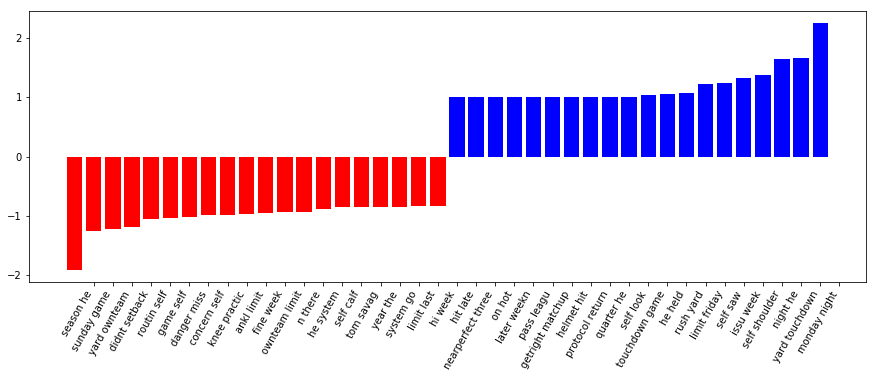

TypeError: 'NoneType' object is not iterable

In [103]:
vocab_bigram.ids_to_words(plot_coefficients(SVM, vocab_bigram.ids_to_words))